In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git # 다운로드
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh # 소스를 실행

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 26.21 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 40.3 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-08-18 04:57:58--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuse

In [4]:
import  numpy as np
from glob import glob
import json
import pandas as pd
from konlpy.tag import Mecab, Okt, Kkma
from tqdm import tqdm



class CustomDataLoader():

    def __init__(self, file_path, doc_name = False, author = False, publisher = False, publisher_year = False, doc_origin = False , summary = 1, num_news = 1000, tokenizer = Okt()):
        """
            json파일들이 담겨있는 디렉토리 경로 및 원하는 feature및 타겟을 지정하면 feature, output, target을 반환
            반환 feature가 기사 원문이 아닌 제목과 같은 다른 str도 반환할 경우, 원문 앞에 붙어서 이어 반환
            입력 데이터 기반으로 토큰화 한 뒤 vocab을 생성하고, 정수로 바꿔서 반환.
            dataset을 return

            예측 후 출력값을 각각 self.num_to_vocab[출력값] 형태로 넣어주면 다시 문자로 변경된다.

        """
        self.file_path = file_path
        self.num_news = num_news
        self.doc_name = doc_name
        self.author = author
        self.publisher = publisher
        self.publisher_year = publisher_year
        self.doc_origin = doc_origin
        self.summary = summary
        self.tokenizer = tokenizer
        self.file_path_list = self.get_path_list()
        self.passage_summary_dict = self.json_to_dict()
        self.df_result = self.dict_to_file()
        self.df_tokenized = self.tokenizing_process()
        self.vocab_dict = self.making_vocab_by_all_features()
        self.df_tokens_to_numbers = self.tokens_to_num()
        self.df_dataset_before_padding = self.feature_and_summary()
        self.df_dataset = self.padding()
        self.dataset = self.to_array()
        self.num_to_vocab = self.num_to_tokens()


    def get_path_list(self):
        file_path_list = glob(self.file_path + "*.json")
        file_path_list = file_path_list[:self.num_news]
        return file_path_list


    def json_to_dict(self):
        """설정한 개수만큼 json파일을 읽고 "원문 tab 요약"으로 txt파일로 return"""
        passage_summary_dict = {}
        passage_values = []
        summary_values = []

        if self.doc_name:
            doc_name_values = []
        if self.author:
            author_values = []
        if self.publisher:
            publisher_values = []
        if self.publisher_year:
            publisher_year_values = []
        if self.doc_origin:
            doc_origin_values = []

        for file_path in self.file_path_list:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)

                if self.doc_name:
                    doc_name_values.append(data['Meta(Acqusition)']['doc_name'])

                if self.author:
                    author_values.append(data['Meta(Acqusition)']['author'])


                if self.publisher:
                    publisher_values.append(data['Meta(Acqusition)']['publisher'])

                if self.publisher_year:
                    publisher_year_values.append(data['Meta(Acqusition)']['publisher_year'])

                if self.doc_origin:
                    doc_origin_values.append(data['Meta(Acqusition)']['doc_origin'])

                passage_values.append(data['Meta(Refine)']['passage'])
                summary_values.append(data['Annotation']['summary'+str(self.summary)])


        if self.doc_name:
            passage_summary_dict['doc_name'] = doc_name_values

        if self.author:
            passage_summary_dict['author'] = author_values

        if self.publisher:
            passage_summary_dict['publisher'] = publisher_values

        if self.publisher_year:
            passage_summary_dict['publisher_year'] = publisher_year_values

        if self.doc_origin:
            passage_summary_dict['doc_origin'] = doc_origin_values

        passage_summary_dict['passage'] = passage_values
        passage_summary_dict['summary'] = summary_values

        return passage_summary_dict


    def dict_to_file(self):
        df_result = pd.DataFrame(self.passage_summary_dict)
        df_result.to_csv(f"./news_summary_dataset_0_{self.num_news}.txt" ,index=False, sep='\t')
        print('txt파일로 출력됐습니다~!')

        return df_result

    def tokenizing_process(self):

        df_tokenized = self.df_result.copy()
        for col in tqdm(self.df_result.columns):
            df_tokenized[col] = df_tokenized[col].apply(self.tokenizer.pos)

        df_tokenized.to_csv(f"./news_summary_tokenized_dataset_0_{self.num_news}.txt" ,index=False, sep='\t')
        print('토큰화된 데이터셋도 출력됐슴둥~!')
        return df_tokenized

    def making_vocab_by_all_features(self):
        features = self.df_tokenized.columns
        tokenized_list = []
        for feature in features:
            for tokenized_sentence in self.df_tokenized[feature]:
                for tokens in tokenized_sentence:
                    token = tokens[0]

                    tokenized_list.append(token)
        print(tokenized_list)
        print(len(tokenized_list))
        tokens_unique = pd.Series(tokenized_list).unique()
        print(len(tokens_unique))
        vocab_feature = {}
        for num, token in enumerate(tokens_unique):
            vocab_feature[token] = num+4

        with open(f"./vocab_all.dict", 'w', encoding='utf-8') as file:
            for key, value in vocab_feature.items():
                file.write(f"{key}\t{value}\n")

        return vocab_feature

    def tokens_to_num(self):
        df_token_to_num = self.df_tokenized.copy()

        for col in self.df_tokenized.columns:
            for idx, tokens in enumerate(self.df_tokenized[col]):
                token_to_num_list = []
                for token in tokens:
                    token_processed = token[0]
                    token_to_num_list.append(self.vocab_dict[token_processed])
                df_token_to_num[col][idx] = token_to_num_list

        df_token_to_num.to_csv('./token_to_numbers.csv', index=False, sep='\t')

        return df_token_to_num

    def feature_and_summary(self):
        dataset = pd.DataFrame()
        dataset['output'] = self.df_tokens_to_numbers['summary'].apply(lambda x : [1] + x)
        dataset['target'] = self.df_tokens_to_numbers['summary'].apply(lambda x : x + [2])

        df_tmp = self.df_tokens_to_numbers.drop(columns='summary')

        def combine_rows(row):
            combined = []
            for col in df_tmp.columns:
                combined += row[col]
                combined.append(3)
            return combined[:-1]

        dataset['feature'] = df_tmp.apply(combine_rows, axis=1)

        return dataset

    def padding(self):
        dataset = self.df_dataset_before_padding.copy()
        feature_length = dataset['feature'].apply(len).max()
        output_length = dataset['output'].apply(len).max()
        target_length = dataset['target'].apply(len).max()

        dataset['feature'] = dataset['feature'].apply(lambda x : x + [0]*(feature_length - len(x)))
        dataset['output'] = dataset['output'].apply(lambda x : x + [0]*(output_length - len(x)))
        dataset['target'] = dataset['target'].apply(lambda x : x + [0]*(target_length - len(x)))

        return dataset

    def to_array(self):
        feature = np.array(self.df_dataset['feature'].tolist())
        output = np.array(self.df_dataset['output'].to_list())
        target = np.array(self.df_dataset['target'].to_list())

        return feature, output, target

    def num_to_tokens(self):
        token_list = ['<Pad>', '<Sos>', "<Eos>", "<구분>"]
        for key, value in self.vocab_dict.items():
            token_list.append(key)

        return token_list

In [5]:
from torch.utils.data import Dataset
class S2SDataset(Dataset):

    def __init__(self, seq_data):
        super().__init__()
        self.feature_in = torch.LongTensor(seq_data[0])
        self.feature_out = torch.LongTensor(seq_data[1])
        self.target = torch.LongTensor(seq_data[2])




    def __len__(self):
        return self.feature_in.shape[0]

    def __getitem__(self, idx):
        return self.feature_in[idx], self.feature_out[idx], self.target[idx]

In [6]:
data = CustomDataLoader('/content/drive/MyDrive/final_project_신문요약/train/')

txt파일로 출력됐습니다~!


100%|██████████| 2/2 [01:46<00:00, 53.48s/it]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35186


In [7]:
n_class = len(data.vocab_dict) + 4
n_hidden = 128

In [8]:
dataset = S2SDataset(data.dataset)

In [9]:
dataset[0]

(tensor([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  12,  15,  16,
          17,  18,  19,  20,  21,  22,  23,  12,  15,  24,  25,  26,  27,  28,
          29,   5,  30,  31,  32,  33,  34,  19,  35,  36,  37,  12,   9,  38,
          26,   9,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  19,
          20,  50,  51,  52,  53,  54,  55,  56,  57,  58,  53,  51,  52,  50,
          54,  55,  56,  57,  58,  12,   5,  59,  60,  61,  62,  19,  20,  21,
          63,  12,  15,  24,  25,  64,  65,   5,  66,  15,  67,  68,  69,  70,
          71,  72,  73,  74,  75,  76,  46,  77,  78,  79,  48,  80,  81,  82,
          19,  20,  12,  15,  24,  83,  84,  85,  86,  87,  88,  58,  89,  58,
          90,  91,  51,  92,  93,  94,  95,  27,  71,  96,  19,  20,  97,  98,
          99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,   9, 110, 111,
         112, 113, 114,  12,  94, 115,  13, 116,   9, 117, 118,  58,  12,  75,
          71, 119, 120, 121, 122, 123,   5, 124, 116

In [10]:
from torch.utils.data import DataLoader
dl = DataLoader(dataset, batch_size=10, shuffle=True)

In [11]:
next(iter(dl))[0].shape

torch.Size([10, 647])

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()

        self.emb = nn.Embedding(n_class, embedding_dim=64)
        self.enc_cell = nn.RNN(input_size=64, hidden_size=n_hidden, dropout=0.5) # 인코딩
        self.dec_cell = nn.RNN(input_size=64, hidden_size=n_hidden, dropout=0.5) # 디코딩
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, enc_input, enc_hidden, dec_input):
        enc_input = self.emb(enc_input)
        dec_input = self.emb(dec_input)
        enc_input = enc_input.transpose(0, 1) # enc_input: [input_size, batch_size, embedding_size]
        dec_input = dec_input.transpose(0, 1) # dec_input: [input_size, batch_size, embedding_size]

        # enc_states : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        _, enc_states = self.enc_cell(enc_input, enc_hidden)

        # outputs : [max_len+1(=6), batch_size, num_directions(=1) * n_hidden(=128)]
        outputs, _ = self.dec_cell(dec_input, enc_states)

        _outputs = outputs.transpose(0, 1) # _outputs (batch_size, input_size(1(E) + 최대 글자 수), n_hidden)
        pred = self.fc(_outputs) # pred : [batch_size, max_len+1(=6), n_class]
        return pred

    def predict(self, input_seq, max_len=50, end_token=2):
        # 1. 인코딩
        input_seq = input_seq.to(device)
        input_embbeded = self.emb(input_seq).transpose(0, 1)
        hidden_state_enc = torch.zeros(1, input_seq.shape[0], self.n_hidden).to(device)
        _, encoder_hidden = self.enc_cell(input_embbeded, hidden_state_enc)

        # 2. 디코딩 시작 토큰 설정
        # 가정: 시작 토큰의 인덱스는 0
        start_token = torch.zeros(input_seq.shape[0]).long().to(device)
        decoder_input = start_token

        # 예측된 시퀀스 저장
        predicted_seq = []

        for _ in range(max_len):
            decoder_input_embbeded = self.emb(decoder_input).unsqueeze(0)
            decoder_output, encoder_hidden = self.dec_cell(decoder_input_embbeded, encoder_hidden)

            # linear layer를 통과하여 예측 결과 얻기
            prediction = self.fc(decoder_output.squeeze(0))

            # 가장 확률이 높은 토큰 선택
            predicted_token = prediction.argmax(dim=-1)

            predicted_seq.append(predicted_token.cpu().numpy())

            # 종료 토큰 체크
            if predicted_token.item() == end_token:
                break

            # 다음 입력값으로 사용
            decoder_input = predicted_token

        return np.array(predicted_seq).T

In [13]:
nn.Embedding(n_class, embedding_dim=64)(next(iter(dl))[0]).shape

torch.Size([10, 647, 64])

In [14]:
nn.Embedding(n_class, embedding_dim=64)(next(iter(dl))[1]).shape

torch.Size([10, 47, 64])

In [15]:
next(iter(dl))[0][0]

tensor([  446,   336,   356,  3270, 22877,  4383,    15, 25048,    58,  4712,
          243,   956,   633, 25049, 22877,    15, 24152,    56,  3464,   956,
          169,  1292,    27, 23714,    49,   451,    25,   994,  7308,    19,
           20, 22877,     9, 16855,     9,    48,  1257,   833,  5132, 13141,
           27,   609,  7308,    19,    20,    64,   169,   892, 13317,     9,
        11477, 22877,     9,  2605, 25050,    58, 22877,  4383,    27, 25051,
          855,    27,    72,  9450, 25052,   205,    27,  2826,   892,    25,
        12304,    19,    20,  1929,     9,  7318, 25053, 25054,   113,  3018,
            9,  9479,  8439,    78,    31,  1221,   236, 12653,  1277, 25055,
           19,    20,   446,   186,    56,  2111, 25056,   451, 25057, 25058,
           27, 25059,  2554,   169,  1883,   320, 17466,    94, 13123,    19,
           20,  3027, 25060,  2898,    94,  1562,  6959,   899,  2160,  3166,
         1188,   307, 25061,   899,  2160,  3166,  1188,   310, 

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [34]:
model = Seq2Seq().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [35]:
loss_list = []
for epoch in range(1000):
    hidden = torch.zeros(1, 10, 128).to(device)
    loss = 0
    for input, output, target in dl:
        input, output, target = input.to(device), output.to(device), target.to(device)
        output = model(input, hidden, output)
        for i in  range(0, len(target)):
            loss += criterion(output[i], target[i])

    loss /= dl.batch_size
    loss /= len(dl)
    loss_list.append(loss)
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0100 cost = 4.653967
Epoch: 0200 cost = 3.398379
Epoch: 0300 cost = 2.277635
Epoch: 0400 cost = 1.510413
Epoch: 0500 cost = 1.020331
Epoch: 0600 cost = 0.708499
Epoch: 0700 cost = 0.508853
Epoch: 0800 cost = 0.383245
Epoch: 0900 cost = 0.304345
Epoch: 1000 cost = 0.254963


In [36]:
save_path = '/content/drive/MyDrive/final_project_신문요약/news_sum_model.pt'

torch.save(model, save_path)

In [37]:
lst = []
for loss in loss_list:
    lst.append(loss.item())

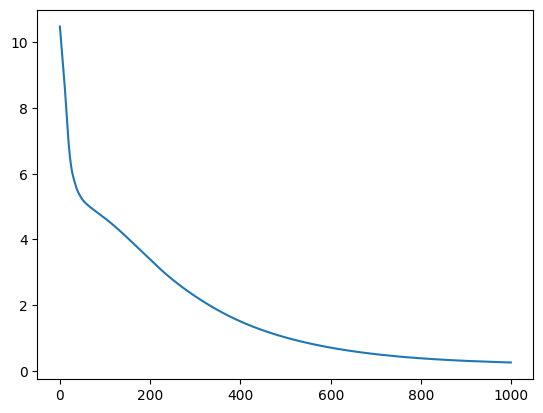

In [38]:
import matplotlib.pyplot as plt
plt.plot(lst)

In [40]:
model.eval()

# 4. 예측
with torch.no_grad():  # gradient 계산 비활성화
    predicted_seq = model.predict(next(iter(dl))[0][0])

AttributeError: ignored

In [ ]:
output[0].shape

In [ ]:
target[0].shape

In [ ]:
len(dl)

In [ ]:
dl.batch_size